In [134]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib import pyplot as plt


from setup import get_task_data

In [135]:
TASK_DATA_NAME = 'AMD.csv'

df = pd.read_csv(get_task_data(TASK_DATA_NAME))

df.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
7083,2008-04-11,6.2100,6.290000,5.970000,6.010000,6.010000,22158500
269,1981-04-09,0.0000,4.333333,4.208333,4.333333,4.333333,748200
2367,1989-07-27,4.4375,4.437500,4.375000,4.437500,4.437500,217200
7164,2008-08-06,4.6200,4.800000,4.480000,4.800000,4.800000,14528300
4227,1996-12-03,12.7500,12.812500,12.062500,12.062500,12.062500,3025600


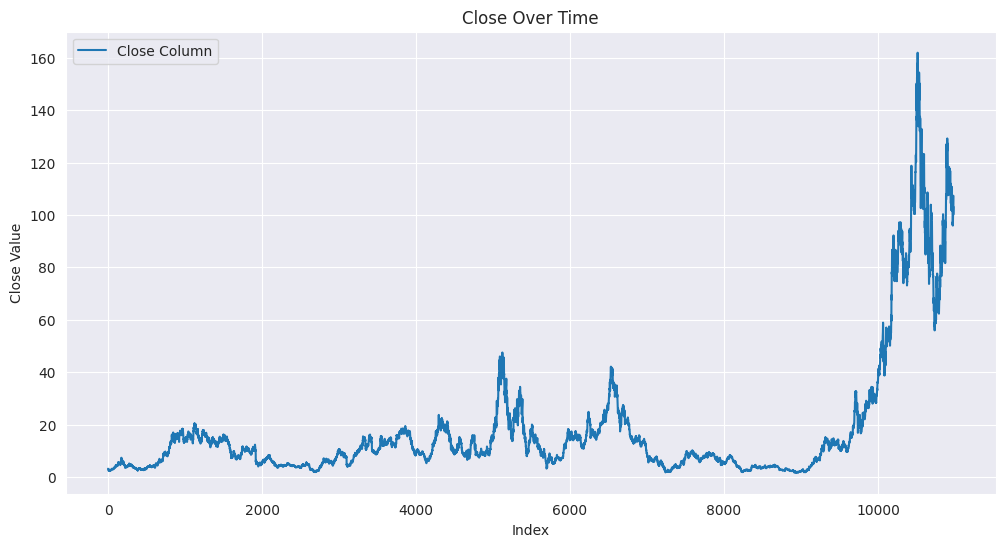

In [136]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Column')
plt.title('Close Over Time')
plt.xlabel('Index')
plt.ylabel('Close Value')
plt.legend()
plt.show()


df = df.iloc[10000:].reset_index() # IMPORTANT! getting recent data (based on chart)

In [137]:
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

check_stationarity(df['Close'])


ADF Statistic: -2.2768475196055245
p-value: 0.17954385670642464
Critical Values: {'1%': -3.4370266558635914, '5%': -2.864487711945291, '10%': -2.5683395116993872}


The ADF test is a statistical test for testing the stationarity of a time series. The test hypothesis is as follows:

Null Hypothesis (H0): The time series has a unit root (it is non-stationary).
Alternative Hypothesis (H1): The time series does not have a unit root (it is stationary).
The ADF test statistic is compared against critical values at different significance levels (1%, 5%, and 10%) to determine whether to reject the null hypothesis.

Analyzing our results, :
1) The ADF statistic is less than the critical values at all significance levels. This suggests that we don't have enough evidence to reject the null hypothesis.

2) The p-value is much higher than common significance levels (e.g., 0.05). A high p-value also suggests that we don't have enough evidence to reject the null hypothesis.

Critical Values: The ADF statistic is not more extreme than the critical values at any significance level.

So, Close column data is not stationary.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

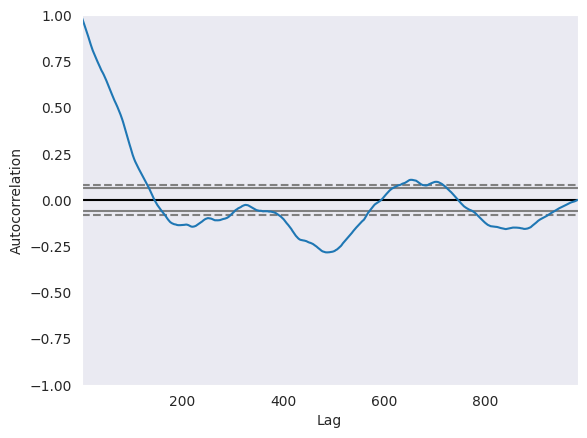

In [138]:
pd.plotting.autocorrelation_plot(df['Close'])

This chart shows us that there is a positive correlation with the first 600-650 lags, 
from which approximately 30-40 may be a good parameter(AR) for ARIMA.

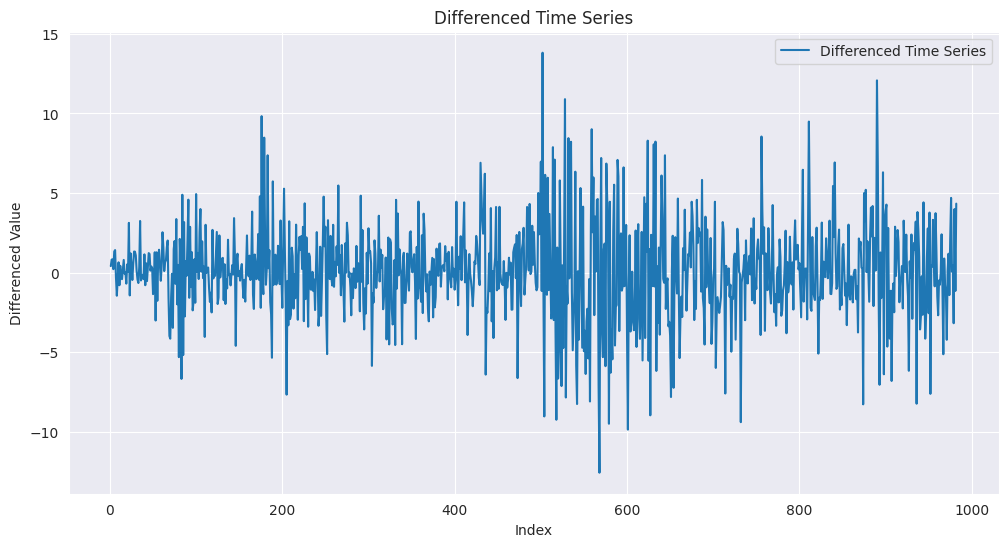

ADF Statistic: -32.57996864740656
p-value: 0.0
Critical Values: {'1%': -3.4370334797663844, '5%': -2.8644907213150725, '10%': -2.568341114581742}


In [139]:
diff_ts = df['Close'].diff().dropna()# Differencing to make the time series stationary
plt.figure(figsize=(12, 6))
plt.plot(diff_ts.index, diff_ts, label='Differenced Time Series')
plt.title('Differenced Time Series')
plt.xlabel('Index')
plt.ylabel('Differenced Value')
plt.legend()
plt.show()
check_stationarity(diff_ts)

As we can see, data is stationary now:
ADF Statistic: The ADF statistic is significantly lower than the critical values at all significance levels (1%, 5%, and 10%). This suggests strong evidence against the null hypothesis, indicating that you can reject the idea of a unit root, and the differenced time series is likely stationary.

BUILDING ARIMA Model

In [140]:
size = int(len(diff_ts) * 0.66)
train, test = diff_ts[0:size], diff_ts[size:len(diff_ts)]

/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  648
Model:                ARIMA(30, 2, 3)   Log Likelihood               -1627.759
Date:                Sun, 12 Nov 2023   AIC                           3323.518
Time:                        18:36:25   BIC                           3475.525
Sample:                             0   HQIC                          3382.494
                                - 648                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1870      0.245     -8.925      0.000      -2.667      -1.707
ar.L2         -2.4858      0.482     -5.156      0.000      -3.431      -1.541
ar.L3         -2.4064      0.494     -4.873      0.0

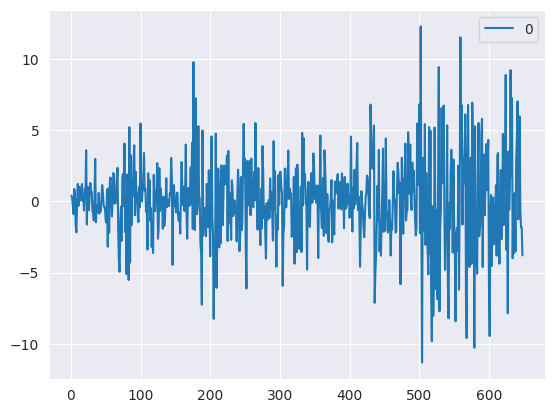

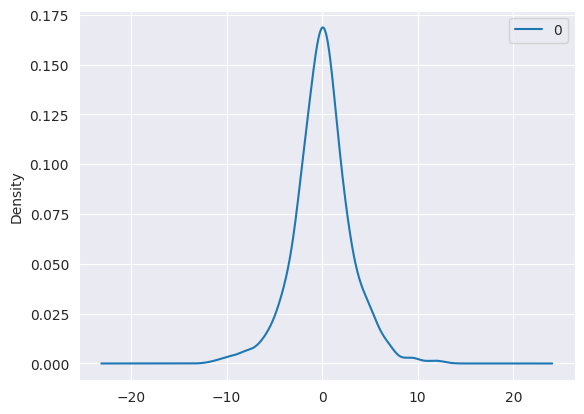

                0
count  648.000000
mean     0.022100
std      2.975506
min    -11.313788
25%     -1.636172
50%      0.048214
75%      1.529379
max     12.278164


In [141]:
model = ARIMA(train, order=(30,2,3)) # 30 - lag (AutoRegression param), 3 - value for making close stationary , 0 for moving average
model_fit = model.fit()

print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

We got a density plot of the residual error values, suggesting the errors are Gaussian.

As for print(model_fit.summary()), we got good values for 



In [142]:
def mean_squared_error(df, actual_col, predicted_col):
    mse = np.mean((df[actual_col] - df[predicted_col]) ** 2)
    return mse

def mean_absolute_error(df, actual_col, predicted_col):
    mae = np.mean(np.abs(df[actual_col] - df[predicted_col]))
    return mae

def root_mean_squared_error(df, actual_col, predicted_col):
    rmse = np.sqrt(mean_squared_error(df, actual_col, predicted_col))
    return rmse

/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


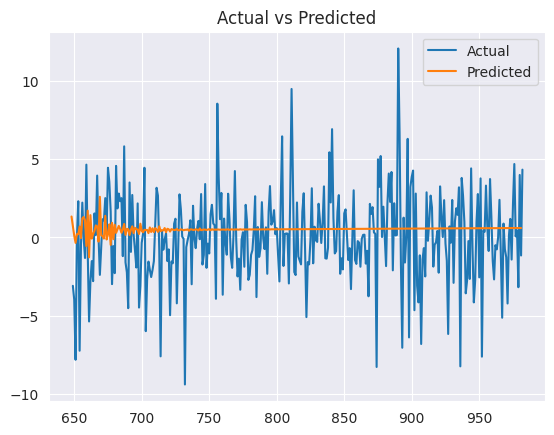

In [143]:
predictions = model_fit.forecast(steps=len(test))

results = pd.DataFrame({'Actual': test, 'Predicted': predictions})

plt.plot(results['Actual'], label='Actual')
plt.plot(results['Predicted'], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

In [144]:
results

,Actual,Predicted
648,NaN,1.332866
649,-3.099999,0.729891
650,-3.980003,0.113669
651,-7.830002,-0.354316
652,0.000000,0.210903
...,...,...
978,0.449997,0.595679
979,-3.189995,0.596130
980,3.989998,0.596587
981,-1.159996,0.597043


In [145]:
results['Actual_scaled'] = (results['Actual'] - results['Actual'].min()) / (results['Actual'].max() - results['Actual'].min())
results['Predicted_scaled'] = (results['Predicted'] - results['Predicted'].min()) / (results['Predicted'].max() - results['Predicted'].min())
mse_value = mean_squared_error(results, 'Actual_scaled', 'Predicted_scaled')
mae_value = mean_absolute_error(results, 'Actual_scaled', 'Predicted_scaled')
rmse_value = root_mean_squared_error(results, 'Actual_scaled', 'Predicted_scaled')

print(f'Mean Squared Error: {mse_value}')
print(f'Mean Absolute Error: {mae_value}')
print(f'Root Mean Squared Error: {rmse_value}')

Mean Squared Error: 0.02227091355256999
Mean Absolute Error: 0.11206062162420023
Root Mean Squared Error: 0.14923442482406662


Analyzing model performance, we got quite decent results for such a messy data.

MSE: The MSE is relatively low, suggesting that, on average, the squared differences between actual and predicted values are small. This is a positive indication of model performance.

MAE: The MAE is also relatively low, indicating that, on average, the absolute differences between actual and predicted values are small. Again, this is a positive sign.

RMSE: The RMSE is similar to the MAE but considers larger errors more heavily due to the squaring. The fact that RMSE is close to MAE suggests that there are not many large errors in the predictions.